In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

This is my notebook for the relax take home challenge, a challenge where I need to build a model to identify adoptes users, users who login at least three times in one week. I will start by looking at the data.

In [223]:
users = pd.read_csv('takehome_users.csv', encoding='latin1')

In [224]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [225]:
engagement = pd.read_csv('takehome_user_engagement.csv')

In [226]:
# Since we are working with a time series, it would be more useful to have the time stamp as the index
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)
engagement.index=engagement.time_stamp
engagement.drop(labels='time_stamp',axis=1,inplace=True)

In [227]:
engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


The following code is going to identify users who have logged in at least three times in a seven day window so that we have our target variable

In [228]:
counts = engagement.groupby([pd.Grouper(freq='7D'), 'user_id']).sum()

In [229]:
adopted_users = counts[counts.visited >=3]

In [230]:
a_u =adopted_users.reset_index()

In [231]:
adopted_ids = a_u.user_id.unique()

In [232]:
adopted_ids

array([  728,  1693,  5297, ...,  8704,  9432, 11682], dtype=int64)

In [233]:
len(adopted_ids)

1445

This is a small number of users relative to the dataset. While this may be expected, I realized this only looks at weeks as efined and is not a rolling window of seven days to find the counts, so it may be lower than what it is supposed to be. The next code will try to identify a rolling window of people in order to get a more accurate number of users.

In [234]:
engagement = pd.read_csv('takehome_user_engagement.csv')

In [235]:
# this function obtains a rolling count of logins grouped by user id and returns the rolling count with indexes based on
# the engagement data
def rolling_count(grp, freq):
    return grp.rolling(freq, on='time_stamp')['user_id'].count()

In [236]:
adopted = engagement.groupby('user_id', as_index=False, group_keys=False).apply(rolling_count, 7)

In [237]:
# This filters the engagement data to only return data on adopted users
ad_us = engagement[adopted >= 3]

In [238]:
len(ad_us.user_id.unique())

2248

This new count of users is much higher than when I used one week intervals, and seems to still be accurate(I eyeballed some of the results randomly to attempt to make sure there were no misidentifications). Now that we have this list, we eill be able to create our target variable, but before that, I'd like to explore the data a little more.

In [239]:
adopted_users = ad_us.user_id.unique()

In [240]:
adopted_list = []
for user in users['object_id']:
    if user in adopted_users:
        adopted_list.append(1)
    else:
        adopted_list.append(0)

In [241]:
users['adopted'] = adopted_list

In [242]:
len(engagement.user_id.unique())

8823

In [243]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


So, we can notice a few things about our data here. Firstly, it seems there isn't too much missing data. Last session creation time has a large number of missing values, this means we have more than 300 users that have an account but never created a session. The other column with missing values is the invited column, which if it is missing, simply means the user was not invited to the service by someone else(I would assume, perhaps I would talk to someone to confirm this in a professional setting). 

To remedy this particular issue, I'm going to create a new column, 'created_session' which will inform whether a user ever created a session. the invited information is contained in the creation source column, and is more granular there, which may be useful for modelling, so I am going to one hot encode the creation source column, so the invited information can be dropped.

In [244]:
users['created_session'] = users.last_session_creation_time.notnull()
users['created_session'] = users['created_session'].astype(int)

In [245]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,created_session
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,1


In [246]:
users.groupby('creation_source').size()

creation_source
GUEST_INVITE          2163
ORG_INVITE            4254
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
dtype: int64

In [247]:
users.groupby('org_id').size().sort_values(ascending=False).head(10)

org_id
0     319
1     233
2     201
3     168
4     159
6     138
5     128
9     124
7     119
10    104
dtype: int64

Beacuase of the large numnber of organization id's, and not knowing if it would make sense to group them somehow, I'm not sure theyd be useful in a model.
The last thing I would like to check is email providers, so I am going to check if there is a smaller number of those which may be useful for one hot encoding.

In [248]:
users['provider'] = users['email'].str.split('@').str[1]

In [249]:
users.groupby('provider').size().sort_values(ascending=False).head(10)

provider
gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
qgjbc.com            2
xybhi.com            2
oqpze.com            2
luque.com            2
dtype: int64

So we have a pretty clear split of a large number of emails from specific providers, and then many 'sketchy' looking provider names. I will create a new column that identifies whether an email is from a major provider or not. It may be prudent to one hot encode by each provider, however I think we already have some proxies for gmail information, and without understanded the specifics of providers, and considering this assignment said to spedn about an hour, I think this particular solution should be useful enough.

In [250]:
major_providers = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com',  'hotmail.com']

In [251]:
maj_prov = []

for prov in users.provider:
    if prov in major_providers:
        maj_prov.append(1)
    else:
        maj_prov.append(0)

In [252]:
users['major_provider'] = maj_prov

In [253]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,created_session,provider,major_provider
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,1,yahoo.com,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1,gustr.com,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1,gustr.com,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,1,yahoo.com,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,1,yahoo.com,1


In [254]:
new_df = users[['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'created_session', 'major_provider', 'adopted']]

In [255]:
dums = pd.get_dummies(users['creation_source'])

In [256]:
mod_dat = dums.join(new_df)

In [257]:
mod_dat.head()

,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list,enabled_for_marketing_drip,created_session,major_provider,adopted
0,1,0,0,0,0,1,0,1,1,0
1,0,1,0,0,0,0,0,1,1,1
2,0,1,0,0,0,0,0,1,1,0
3,1,0,0,0,0,0,0,1,1,0
4,1,0,0,0,0,0,0,1,1,0


So now that we have a set of model data, we can perform some modelling and check feature importances. I will be using XGBoost for this classifier, as it provides robust feature importance information.

In [296]:
from sklearn.model_selection import train_test_split

In [297]:
X = mod_dat.iloc[:,:-1]
y = mod_dat.iloc[:,-1]

In [298]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [332]:
from xgboost import XGBClassifier
import xgboost as xgb

In [334]:
from xgboost import plot_importance

In [301]:
fitted = xgc.fit(X_train, y_train)

In [302]:
pred = xgc.predict(X_test)

In [319]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn import metrics

In [304]:
confusion_matrix(y_test, pred)

array([[2922,    0],
       [ 678,    0]], dtype=int64)

In [305]:
pprob = xgc.predict_proba(X_test)

In [320]:
log_loss(y_test, pprob)

0.41563104579880017

In [322]:
print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))

Accuracy: 0.8116666666666666
Precision: 0.0
Recall: 0.0


D:\Ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Well, this model doesn't perform well, presumably because of the class imbalance, let us try to use SMOTE to remedy that.

In [308]:
from imblearn.over_sampling import SMOTE

In [309]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

In [310]:
X_train = pd.DataFrame(X_train, columns = ['GUEST_INVITE','ORG_INVITE','PERSONAL_PROJECTS','SIGNUP','SIGNUP_GOOGLE_AUTH', 'opted_in_to_mailing_list','enabled_for_marketing_drip','created_session','major_provider'])

In [318]:
fitted2 = xgc.fit(X_train, y_train)

In [312]:
pred2 = xgc.predict(X_test)

In [313]:
confusion_matrix(y_test, pred2)

array([[1004, 1918],
       [  15,  663]], dtype=int64)

In [314]:
pprob2 = xgc.predict_proba(X_test)

In [323]:
log_loss(y_test, pprob2)

0.5884401231622906

In [324]:
print("Accuracy:",metrics.accuracy_score(y_test, pred2))
print("Precision:",metrics.precision_score(y_test, pred2))
print("Recall:",metrics.recall_score(y_test, pred2))

Accuracy: 0.46305555555555555
Precision: 0.25687717938783416
Recall: 0.9778761061946902


So this model is a lot better at indentifying the 'negative' case, which here is actually our positive case, this can be observed in the cell below. Although it is much worse than our base model in terms of accuracy, it does actually attempt to predict other cases than the most common case, let us observe the feature importances now.

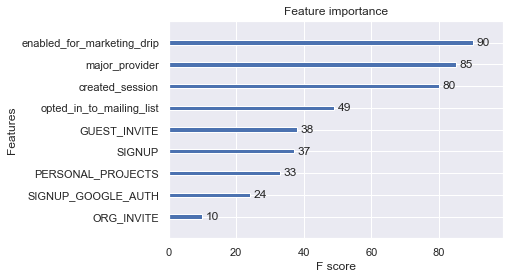

In [336]:
plot_importance(fitted2)

observing these feature importances, it seems the most important feature is if a user signed up for the marketing drip, followed by whther ot not the user used a major e-mail provider, and if they ever created a session. Considering I created the major provider and create session variables, I am pretty proud to have thought of them. Were I to look into this more, I would want to oberve if the users who did not use a major provider ever created a session, as there may be perhaps spam accounts linked to those non-major provier e-mails. I'd also look into pushin users to create sessions when they sign up to create buy in to the system.